In [72]:
%load_ext autoreload
%aimport utils
%autoreload 1
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. The mathematical building blocks of neural networks

## 2.1 A first look at a neural network

**Listing 2.1: Loading the MNIST dataset**

Type of train_images: <class 'numpy.ndarray'>
Shape of train_images: (60000, 28, 28)

Type of train_labels: <class 'numpy.ndarray'>
Shape of train_labels: (60000,)
train_labels: [5 0 4 ... 5 6 8]

Type of test_images: <class 'numpy.ndarray'>
Shape of test_images: (10000, 28, 28)

Type of test_labels: <class 'numpy.ndarray'>
Shape of test_labels: (10000,)
test_labels: [7 2 1 ... 4 5 6]



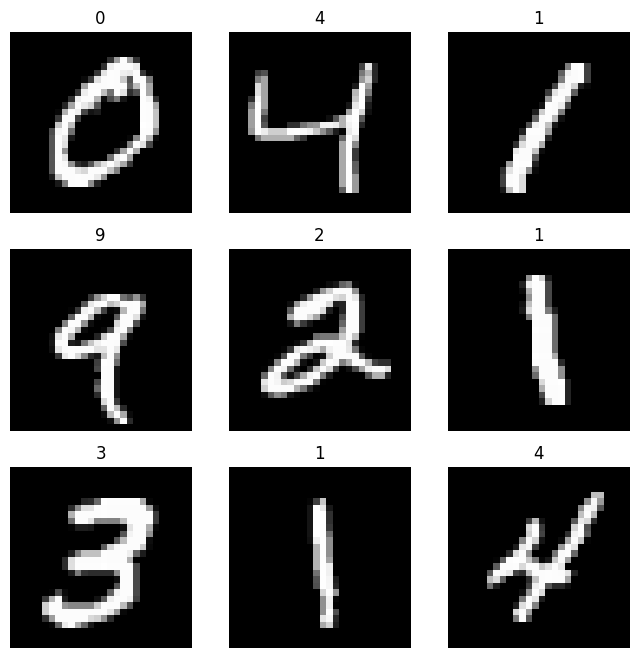

In [79]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# In Keras over TensorFlow, MNIST data gets loaded as numpy arrays.
utils.tensor_info(train_images, "train_images")
utils.tensor_info(train_labels, "train_labels")
utils.tensor_info(test_images, "test_images")
utils.tensor_info(test_labels, "test_labels")

# Draw first 9 images:
utils.draw_grid(train_images[:10], train_labels[:10])

Type of train_dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 128
Shape of features in first batch of train_dataloader: torch.Size([128, 1, 28, 28])
Shape of labels in first batch of train_dataloader: torch.Size([128]) torch.int64

Type of test_dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 128
Shape of features in first batch of test_dataloader: torch.Size([128, 1, 28, 28])
Shape of labels in first batch of test_dataloader: torch.Size([128]) torch.int64



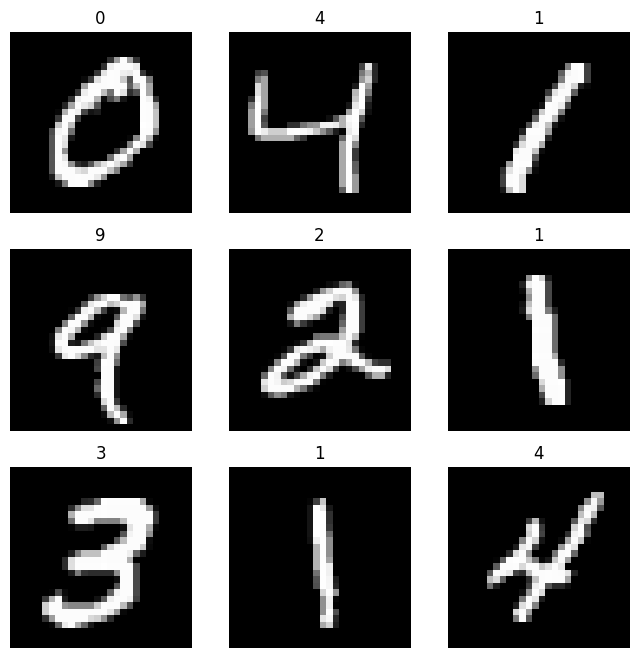

In [80]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# PyTorch has objects Dataset to hold the samples and labels, and DataLoader to iterate easily.
training_data = MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
# Dataloaders support automatic batching!
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_data = MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

utils.tensor_info(train_dataloader, "train_dataloader")
utils.tensor_info(test_dataloader, "test_dataloader")
# They are identical as both work in 128-sized batches.
# Dimension corresponds to [Samples, Color, Height, Width]

# Draw first nine images from first batch. I could iterate directly over the dataset, but didn't feel like it:
X, y = next(iter(train_dataloader))
utils.draw_grid(X[:10], [label.item() for label in y[:10]])

**Listing 2.2: The network architecture**

In [81]:
from tensorflow import keras
from tensorflow.keras import layers
# Keras is very straightforward!
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [82]:
# Build the model and print the summary
model.build(input_shape=(1,28*28))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (1, 512)                  401920    
                                                                 
 dense_15 (Dense)            (1, 10)                   5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
from torch import nn
import torch.nn.functional as F
# In PyTorch, models inherit from nn.Module. We define the layers in the constructor and the forward
# prop in the function forward. More verbose but easier to customize.
class TorchModel(nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        output = self.stack(x)
        return F.log_softmax(output, dim=1)

In [98]:
# Torchsummary prints very similar information to Keras summary()
from torchsummary import summary
torchmodel = TorchModel()
summary(torchmodel, input_size=(1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


**The compilation step**

In [86]:
# Again, Keras is pretty straightforward here.
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [109]:
import torch.optim as optim
import torch.nn as nn

# Define RMSprop optimizer
optimizer = optim.RMSprop(torchmodel.parameters())

# Define loss function (CrossEntropyLoss for integer labels)
criterion = nn.CrossEntropyLoss()

# Function to calculate accuracy
def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

def train(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and calculate accuracy
        total_loss += loss.item()
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_samples += y.size(0)

    # Calculate overall average loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


**Preparing the image data**

In [88]:

# In tf, we used the numpy array operation reshape and divided by the scalar 255
# so that all values go between 0 and 1.
# The MNIST dataset loaded in PyTorch is already normalized, and it gets flattened
# in the very neural network.
train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255


**"Fitting" the model**

In [89]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2561 - accuracy: 0.9262
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1034 - accuracy: 0.9699
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0672 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0485 - accuracy: 0.9855
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0362 - accuracy: 0.9890


In [110]:
# Manually write the loop in PyTorch!
epochs = 5
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    avg_loss, accuracy = train(train_dataloader, torchmodel, criterion, optimizer)
    print(f"Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/5
Average Loss: 0.0793, Accuracy: 0.9900
Epoch 2/5
Average Loss: 0.0417, Accuracy: 0.9932
Epoch 3/5
Average Loss: 0.0363, Accuracy: 0.9942
Epoch 4/5
Average Loss: 0.0398, Accuracy: 0.9937
Epoch 5/5
Average Loss: 0.0415, Accuracy: 0.9943


**Using the model to make predictions**

In [118]:
# Keras
test_digits = test_images[:10]
predictions = model.predict(test_digits)
print(predictions[0])
#PyTorch
test_images_tensor = torch.tensor(test_images)
torchmodel.eval()
with torch.no_grad():   
    logits = torchmodel(test_images_tensor)

probabilities = torch.softmax(logits, dim=1)
print(probabilities[0])

1/1 [==============================] - 0s 15ms/step
[5.1952638e-09 3.4508549e-11 2.6030830e-06 2.2939364e-05 5.0907846e-13
 3.0164669e-09 4.9674484e-15 9.9997437e-01 1.7992138e-08 1.0577582e-07]
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 7.2129e-40])


In [121]:

print(f"Keras predicts: {predictions[0].argmax()}. PyTorch predicts: {probabilities[0].argmax()}. The label is {test_labels[0]}.")


Keras predicts: 7. PyTorch predicts: 7. The label is 7


**Evaluating the model on new data**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

## Data representations for neural networks

### Scalars (rank-0 tensors)

In [ ]:
import numpy as np
x = np.array(12)
x

In [ ]:
x.ndim

### Vectors (rank-1 tensors)

In [ ]:
x = np.array([12, 3, 6, 14, 7])
x

In [ ]:
x.ndim

### Matrices (rank-2 tensors)

In [ ]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
x.ndim

### Rank-3 and higher-rank tensors

In [ ]:
x = np.array([[[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]]])
x.ndim

### Key attributes

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images.ndim

In [ ]:
train_images.shape

In [ ]:
train_images.dtype

**Displaying the fourth digit**

In [ ]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [ ]:
train_labels[4]

### Manipulating tensors in NumPy

In [ ]:
my_slice = train_images[10:100]
my_slice.shape

In [ ]:
my_slice = train_images[10:100, :, :]
my_slice.shape

In [ ]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

In [ ]:
my_slice = train_images[:, 14:, 14:]

In [ ]:
my_slice = train_images[:, 7:-7, 7:-7]

### The notion of data batches

In [ ]:
batch = train_images[:128]

In [ ]:
batch = train_images[128:256]

In [ ]:
n = 3
batch = train_images[128 * n:128 * (n + 1)]

### Real-world examples of data tensors

### Vector data

### Timeseries data or sequence data

### Image data

### Video data

## The gears of neural networks: tensor operations

### Element-wise operations

In [ ]:
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

In [ ]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In [ ]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: {0:.2f} s".format(time.time() - t0))

In [ ]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

### Broadcasting

In [ ]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))

In [ ]:
y = np.expand_dims(y, axis=0)

In [ ]:
Y = np.concatenate([y] * 32, axis=0)

In [ ]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

In [ ]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)

### Tensor product

In [ ]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)

In [ ]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

In [ ]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

### Tensor reshaping

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))

In [ ]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

In [ ]:
x = x.reshape((6, 1))
x

In [ ]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

### Geometric interpretation of tensor operations

### A geometric interpretation of deep learning

## The engine of neural networks: gradient-based optimization

### What's a derivative?

### Derivative of a tensor operation: the gradient

### Stochastic gradient descent

### Chaining derivatives: The Backpropagation algorithm

#### The chain rule

#### Automatic differentiation with computation graphs

#### The gradient tape in TensorFlow

In [ ]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
x = tf.Variable(tf.random.uniform((2, 2)))
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

## Looking back at our first example

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

### Reimplementing our first example from scratch in TensorFlow

#### A simple Dense class

In [ ]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### A simple Sequential class

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [ ]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### A batch generator

In [ ]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step

In [ ]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [ ]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop

In [ ]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

### Evaluating the model

In [ ]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

## Summary